In [1]:
# Install required packages
!pip install ctgan sdv scipy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
real_data = pd.read_csv('/content/preprocessed_data1.csv')

# Data Analysis
print("Original Data Shape:", real_data.shape)
print("\nLabel Distribution:")
print(real_data['Label_encoded'].value_counts())


Original Data Shape: (13692, 38)

Label Distribution:
Label_encoded
0    1956
2    1956
4    1956
6    1956
1    1956
3    1956
5    1956
Name: count, dtype: int64


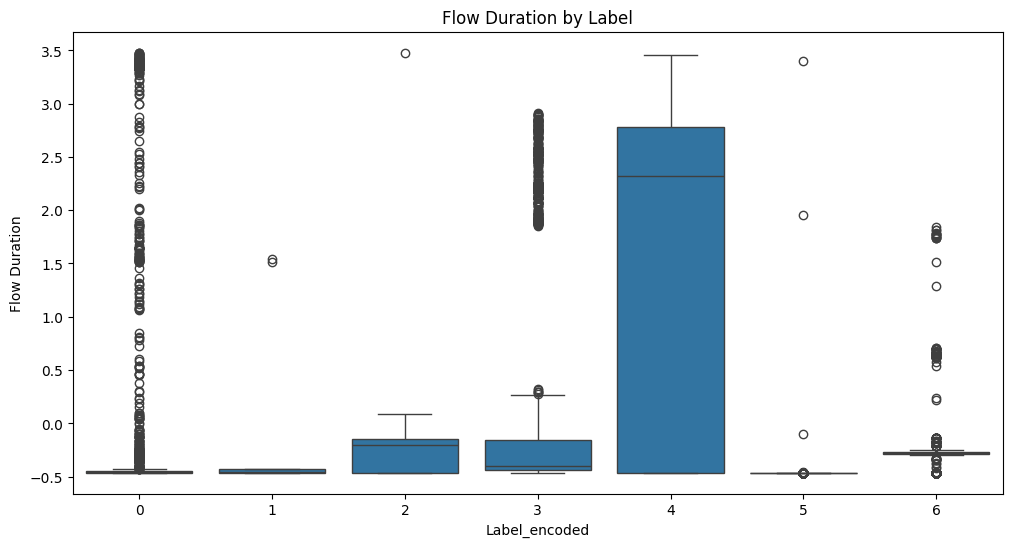

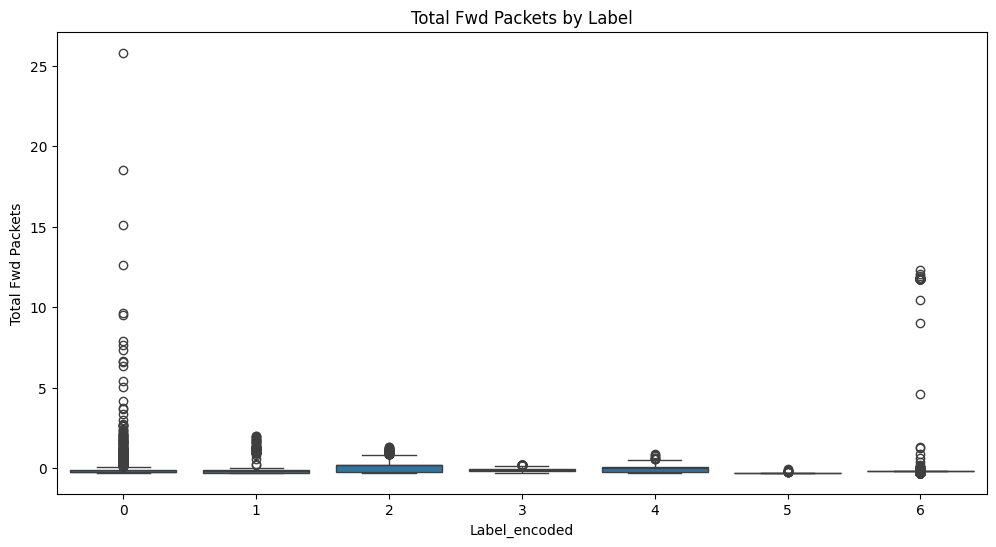

In [4]:
# Visualize some features
plt.figure(figsize=(12, 6))
sns.boxplot(data=real_data, x='Label_encoded', y='Flow Duration')
plt.title('Flow Duration by Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=real_data, x='Label_encoded', y='Total Fwd Packets')
plt.title('Total Fwd Packets by Label')
plt.show()

In [5]:
# Custom metric for boxplot similarity
def boxplot_similarity(real_data, synthetic_data, feature, label_col='Label_encoded'):
    """
    Calculate similarity between real and synthetic data boxplots for a given feature
    Returns a similarity score between 0 and 1 (1 being most similar)
    """
    real_stats = real_data.groupby(label_col)[feature].describe()
    synth_stats = synthetic_data.groupby(label_col)[feature].describe()

    # Calculate similarity for each statistic
    mean_sim = 1 - abs(real_stats['mean'] - synth_stats['mean']) / (real_stats['mean'].max() - real_stats['mean'].min())
    std_sim = 1 - abs(real_stats['std'] - synth_stats['std']) / (real_stats['std'].max() - real_stats['std'].min())
    min_sim = 1 - abs(real_stats['min'] - synth_stats['min']) / (real_stats['min'].max() - real_stats['min'].min())
    max_sim = 1 - abs(real_stats['max'] - synth_stats['max']) / (real_stats['max'].max() - real_stats['max'].min())
    q1_sim = 1 - abs(real_stats['25%'] - synth_stats['25%']) / (real_stats['25%'].max() - real_stats['25%'].min())
    q3_sim = 1 - abs(real_stats['75%'] - synth_stats['75%']) / (real_stats['75%'].max() - real_stats['75%'].min())

    # Average similarity across all statistics and labels
    overall_sim = (mean_sim.mean() + std_sim.mean() + min_sim.mean() +
                  max_sim.mean() + q1_sim.mean() + q3_sim.mean()) / 6

    return max(0, min(1, overall_sim))  # Ensure between 0 and 1

In [6]:

# Identify continuous and discrete columns
continuous_cols = []
discrete_cols = []

for col in real_data.columns:
    if real_data[col].nunique() > 20 and pd.api.types.is_numeric_dtype(real_data[col]):
        continuous_cols.append(col)
    elif col != 'Label_encoded':
        discrete_cols.append(col)

print("Continuous columns:", continuous_cols)
print("Discrete columns:", discrete_cols)


Continuous columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s', 'Min Packet Length', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std']
Discrete columns: ['Fwd PSH Flags', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio']


In [7]:
# Select features to monitor for boxplot similarity
boxplot_features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Length of Fwd Packets',
    'Flow Bytes/s',
    'Flow Packets/s'
]

In [8]:
# Train the CTGAN model
ctgan = CTGAN(
    embedding_dim=128,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=1000,
    discriminator_steps=2,
    epochs=1500,
    pac=10,
    cuda=True,
    verbose=True
)

In [9]:
# Fit the model
ctgan.fit(real_data, discrete_cols, epochs=1500)

# Generate synthetic data
synthetic_data = ctgan.sample(20000)

# Save synthetic data
synthetic_data.to_csv('synthetic_network_traffic.csv', index=False)


Gen. (-0.98) | Discrim. (-0.05): 100%|██████████| 1500/1500 [7:54:21<00:00, 18.97s/it]


In [10]:
# If you're using Google Colab, use this to download the file:
from google.colab import files
files.download("synthetic_network_traffic.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Evaluation functions
def evaluate_synthetic_data(real_data, synthetic_data):
    """Evaluate the quality of synthetic data compared to real data"""
    results = {}

    # 1. Compare label distributions
    real_counts = real_data['Label_encoded'].value_counts(normalize=True)
    synth_counts = synthetic_data['Label_encoded'].value_counts(normalize=True)
    label_similarity = 1 - abs(real_counts - synth_counts).mean()
    results['Label Distribution Similarity'] = label_similarity

    # 2. Compare statistical properties
    stats_similarities = {}
    for feature in boxplot_features:
        stats_similarities[feature] = boxplot_similarity(real_data, synthetic_data, feature)
    results['Feature Statistics Similarity'] = stats_similarities

    # 3. Compare correlations
    real_corr = real_data[continuous_cols].corr().values
    synth_corr = synthetic_data[continuous_cols].corr().values
    corr_similarity = 1 - np.abs(real_corr - synth_corr).mean()
    results['Correlation Similarity'] = corr_similarity

    # 4. Kolmogorov-Smirnov test for continuous features
    ks_results = {}
    for feature in continuous_cols:
        ks_stat, _ = stats.ks_2samp(real_data[feature], synthetic_data[feature])
        ks_results[feature] = 1 - ks_stat  # Convert to similarity score
    results['KS Test Similarity'] = ks_results

    return results

In [12]:
# Run evaluation
evaluation_results = evaluate_synthetic_data(real_data, synthetic_data)


In [13]:
# Print evaluation results
print("\nEvaluation Results:")
print("="*50)
print(f"Label Distribution Similarity: {evaluation_results['Label Distribution Similarity']:.4f}")
print(f"Correlation Similarity: {evaluation_results['Correlation Similarity']:.4f}")

print("\nFeature Statistics Similarity:")
for feature, score in evaluation_results['Feature Statistics Similarity'].items():
    print(f"{feature}: {score:.4f}")

print("\nKS Test Similarity (1 is best):")
for feature, score in evaluation_results['KS Test Similarity'].items():
    print(f"{feature}: {score:.4f}")


Evaluation Results:
Label Distribution Similarity: 0.9809
Correlation Similarity: 0.9256

Feature Statistics Similarity:
Flow Duration: 0.0000
Total Fwd Packets: 0.0000
Total Length of Fwd Packets: 0.0000
Flow Bytes/s: 0.0000
Flow Packets/s: 0.0000

KS Test Similarity (1 is best):
Destination Port: 0.6636
Flow Duration: 0.6950
Total Fwd Packets: 0.7838
Total Length of Fwd Packets: 0.6751
Fwd Packet Length Max: 0.7250
Fwd Packet Length Min: 0.6243
Fwd Packet Length Mean: 0.7500
Bwd Packet Length Max: 0.7078
Bwd Packet Length Min: 0.5636
Flow Bytes/s: 0.6341
Flow Packets/s: 0.5427
Flow IAT Mean: 0.7579
Flow IAT Std: 0.7754
Flow IAT Min: 0.4118
Fwd IAT Min: 0.2879
Bwd IAT Total: 0.4876
Bwd IAT Mean: 0.5435
Bwd IAT Std: 0.6613
Bwd IAT Max: 0.5674
Fwd Header Length: 0.8301
Bwd Header Length: 0.8749
Bwd Packets/s: 0.6065
Min Packet Length: 0.5413
Init_Win_bytes_forward: 0.8420
Init_Win_bytes_backward: 0.6765
act_data_pkt_fwd: 0.5566
Active Mean: 0.3394
Active Std: 0.3785
Active Max: 0.3849


In [14]:
# Visual comparison for key features
def plot_comparison(real_data, synthetic_data, feature):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=real_data, x='Label_encoded', y=feature)
    plt.title(f'Real Data - {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=synthetic_data, x='Label_encoded', y=feature)
    plt.title(f'Synthetic Data - {feature}')

    plt.tight_layout()
    plt.show()


Visual Comparisons:


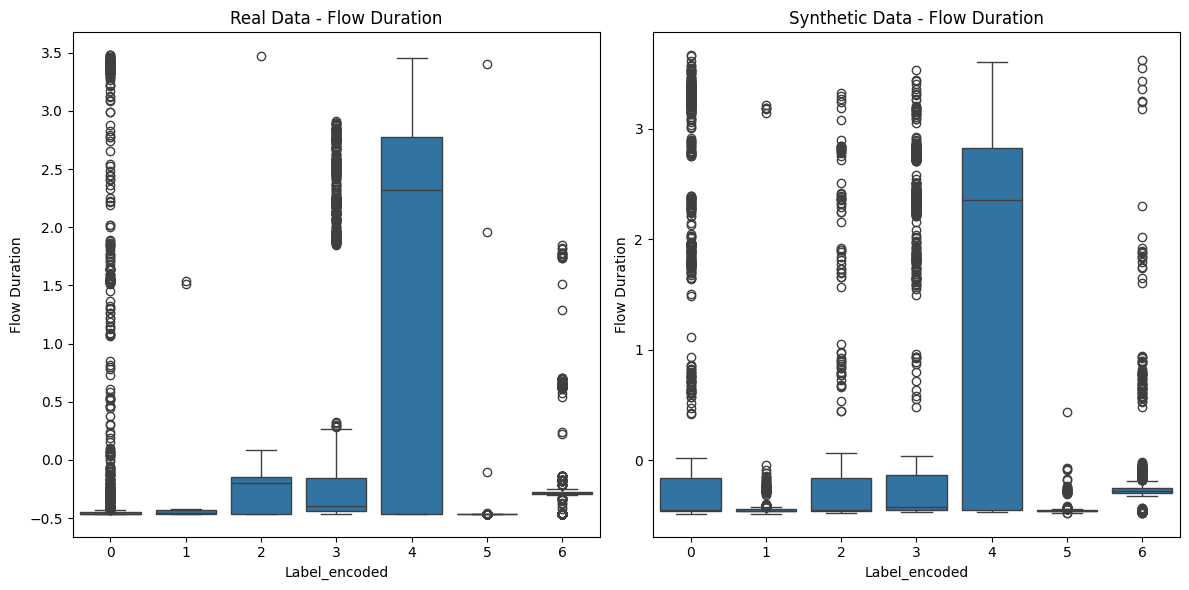

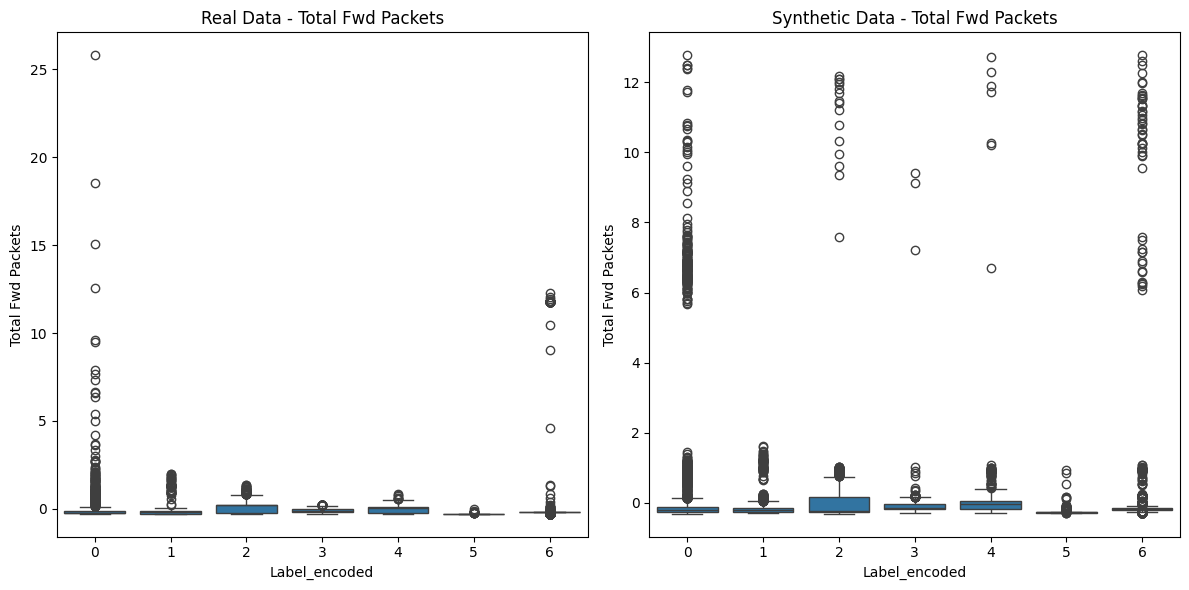

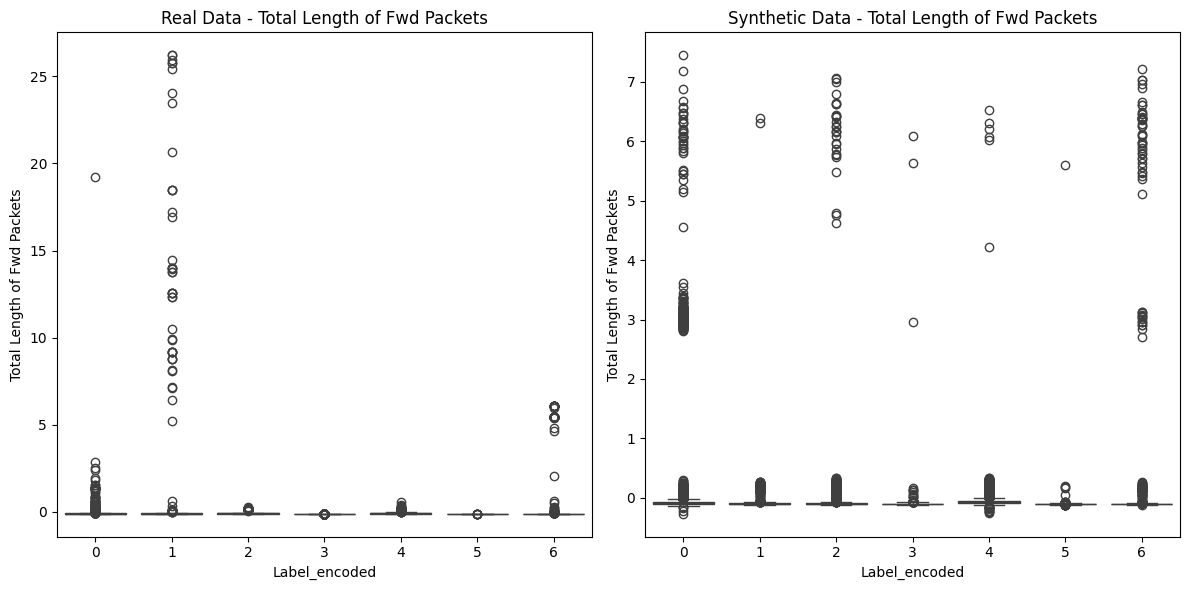

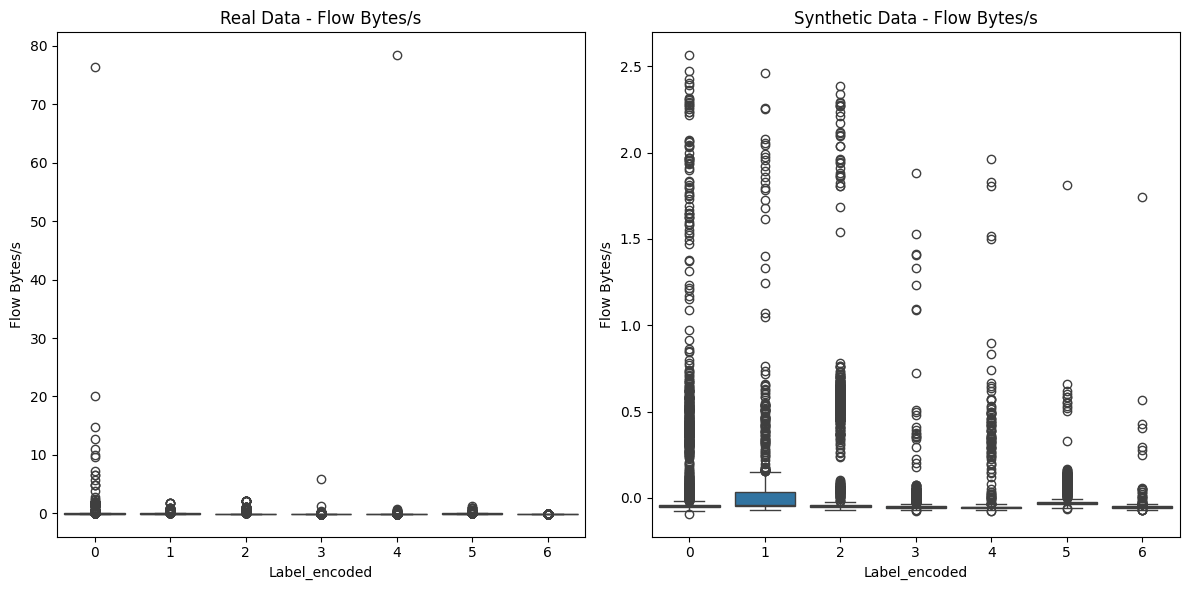

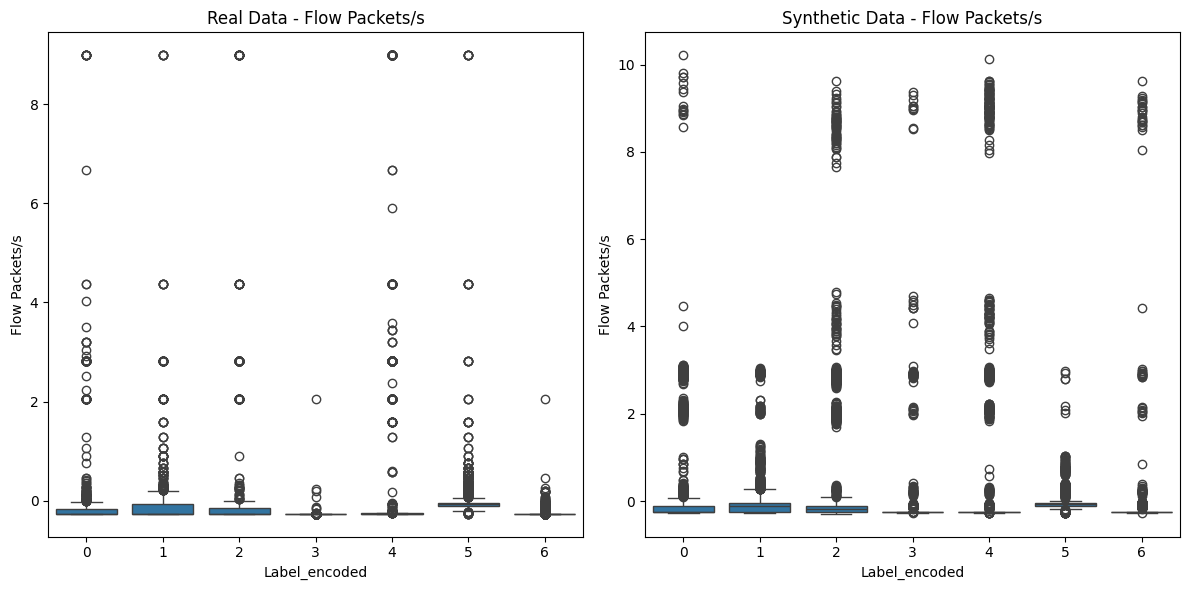

In [15]:
print("\nVisual Comparisons:")
for feature in boxplot_features[:5]:  # Plot first 5 features
    plot_comparison(real_data, synthetic_data, feature)


In [16]:
# PCA visualization
def plot_pca(real_data, synthetic_data):
    # Combine data
    real_data['type'] = 'real'
    synthetic_data['type'] = 'synthetic'
    combined = pd.concat([real_data, synthetic_data])

    # Scale data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(combined[continuous_cols])

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled)

    # Plot
    plt.figure(figsize=(12, 8))
    for label in combined['type'].unique():
        idx = combined['type'] == label
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=label, alpha=0.5)
    plt.legend()
    plt.title('PCA of Real vs Synthetic Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()



PCA Visualization:


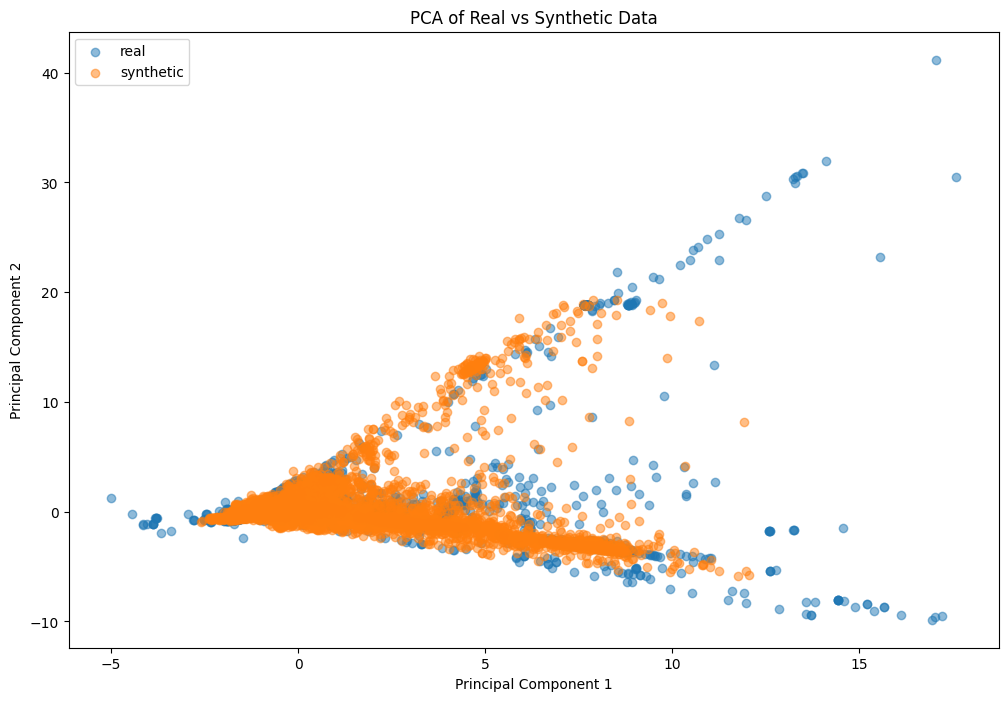

In [18]:
print("\nPCA Visualization:")
plot_pca(real_data, synthetic_data)